# Split the data in train and test set

In [90]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv("../data/interim/cleaned_yield_tables.csv")

features = [
    "yield_class",
    "age",
    "average_height",
    "dbh",
    "taper",
    "trees_per_ha",
    "basal_area",
]
numerical_features = [x for x in features if x != "yield_class"]
target_variable = "tree_type"
df.head()

,tree_type,yield_class,age,average_height,dbh,taper,trees_per_ha,basal_area
0,coniferous,15.0,20.0,5.3,11.5,0.396,2585.0,26.8
1,coniferous,15.0,30.0,10.6,16.7,0.458,1708.0,37.5
2,coniferous,15.0,40.0,15.7,21.6,0.460,1266.0,46.3
3,coniferous,15.0,50.0,20.5,26.1,0.456,1003.0,53.5
4,coniferous,15.0,60.0,24.6,30.2,0.451,830.0,59.4


In [91]:
def create_stratified_splits(X, y, test_size=0.2, val_size=0.2, random_state=42):
    """Create stratified train/validation/test splits"""

    # First split: separate test set
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    # Second split: separate train/validation from remaining data
    val_size_adjusted = val_size / (1 - test_size)  # Adjust for remaining data
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp,
        y_temp,
        test_size=val_size_adjusted,
        stratify=y_temp,
        random_state=random_state,
    )

    # Verify class distributions
    print("Class distributions:")
    print(f"Train: {y_train.value_counts(normalize=True)}")
    print(f"Val:   {y_val.value_counts(normalize=True)}")
    print(f"Test:  {y_test.value_counts(normalize=True)}")

    return X_train, X_val, X_test, y_train, y_val, y_test


X = df.drop("tree_type", axis=1)
y = df["tree_type"]
X_train, X_val, X_test, y_train, y_val, y_test = create_stratified_splits(X, y)

Class distributions:
Train: tree_type
coniferous    0.805383
deciduous     0.194617
Name: proportion, dtype: float64
Val:   tree_type
coniferous    0.806211
deciduous     0.193789
Name: proportion, dtype: float64
Test:  tree_type
coniferous    0.804969
deciduous     0.195031
Name: proportion, dtype: float64


## Numerical Feature Transformations

Numerical features often need transformation to reveal clearer relationships with your classification targets. Raw values can be skewed, contain outliers, or have non-linear patterns that standard algorithms may fail to capture. Applying the right transformation can:

- Make patterns more visible to linear classifiers.
- Improve performance for all model families.
- Increase model stability and interpretability.


In [92]:
def simple_log_transform(X_train, X_val, X_test, num_columns):
    """Simple log transformation for skewed features"""

    for col in num_columns:
        # Check if all values are positive
        if (X_train[col] > 0).all():
            X_train[col] = np.log(X_train[col])
            X_val[col] = np.log(X_val[col])
            X_test[col] = np.log(X_test[col])
            print(f"Applied log transform to {col}")
        else:
            print(f"Cannot log transform {col} - contains zeros or negatives")

    return X_train, X_val, X_test


def simple_scaling(X_train, X_val, X_test, num_columns):
    """Simple standard scaling for numerical features"""

    scaler = StandardScaler()

    # Fit on training data only
    X_train[num_columns] = scaler.fit_transform(X_train[num_columns])
    X_val[num_columns] = scaler.transform(X_val[num_columns])
    X_test[num_columns] = scaler.transform(X_test[num_columns])

    return X_train, X_val, X_test, scaler


def handle_outliers_simple(X_train, X_val, X_test, num_columns):
    """Simple outlier handling using percentiles"""

    for col in num_columns:
        # Calculate 5th and 95th percentiles from training data
        lower_bound = X_train[col].quantile(0.05)
        upper_bound = X_train[col].quantile(0.95)

        # Cap values
        X_train[col] = X_train[col].clip(lower_bound, upper_bound)
        X_val[col] = X_val[col].clip(lower_bound, upper_bound)
        X_test[col] = X_test[col].clip(lower_bound, upper_bound)

        print(f"Capped {col} between {lower_bound:.2f} and {upper_bound:.2f}")

    return X_train, X_val, X_test


X_train_for_scaling = X_train.copy()
X_val_for_scaling = X_val.copy()
X_test_for_scaling = X_test.copy()

# Example pipeline (for reference, not strictly necessary since we run steps manually above)
X_train_transformed, X_val_transformed, X_test_transformed = simple_log_transform(
    X_train_for_scaling, X_val_for_scaling, X_test_for_scaling, numerical_features
)
(
    X_train_outlier_handled,
    X_val_outlier_handled,
    X_test_outlier_handled,
) = handle_outliers_simple(
    X_train_transformed, X_val_transformed, X_test_transformed, numerical_features
)
X_train_scaled, X_val_scaled, X_test_scaled, scaler = simple_scaling(
    X_train_outlier_handled,
    X_val_outlier_handled,
    X_test_outlier_handled,
    numerical_features,
)

Applied log transform to age
Applied log transform to average_height
Applied log transform to dbh
Applied log transform to taper
Applied log transform to trees_per_ha
Applied log transform to basal_area
Capped age between 3.40 and 5.35
Capped average_height between 2.08 and 3.61
Capped dbh between 2.36 and 3.98
Capped taper between -0.92 and -0.66
Capped trees_per_ha between 5.30 and 7.96
Capped basal_area between 2.96 and 4.11


## Select features

In [93]:
selector = SelectKBest(mutual_info_classif, k=len(features) - 2)
X_train_sel = selector.fit_transform(X_train_scaled, y_train)

for col in X_train_scaled.columns:
    if col in selector.get_feature_names_out():
        print(f"Selected feature: {col}: True")
    else:
        print(f"Selected feature: {col}: False")

print("=" * 20)

# Wrapper: RFE with logistic regression
model = LogisticRegression(max_iter=500)
rfe = RFE(model, n_features_to_select=len(features) - 2)
X_train_rfe = rfe.fit_transform(X_train_scaled, y_train)

for index, i in enumerate(rfe.support_):
    print(f"Selected feature: {X_train.columns[index]}: {i}")

Selected feature: yield_class: True
Selected feature: age: True
Selected feature: average_height: False
Selected feature: dbh: False
Selected feature: taper: True
Selected feature: trees_per_ha: True
Selected feature: basal_area: True
Selected feature: yield_class: False
Selected feature: age: True
Selected feature: average_height: True
Selected feature: dbh: True
Selected feature: taper: False
Selected feature: trees_per_ha: True
Selected feature: basal_area: True


## Rate the features using MI scores

In [94]:
mi_scores = mutual_info_classif(X_train_scaled, y_train, random_state=0)
mi_df = pd.Series(mi_scores, index=X_train_scaled.columns).sort_values(ascending=False)
print("Top features by MI:\n", mi_df.head(10))

Top features by MI:
 basal_area        0.155795
age               0.074844
taper             0.044154
yield_class       0.035405
trees_per_ha      0.030549
average_height    0.000000
dbh               0.000000
dtype: float64


## Visualize feature distributions before and after transformations

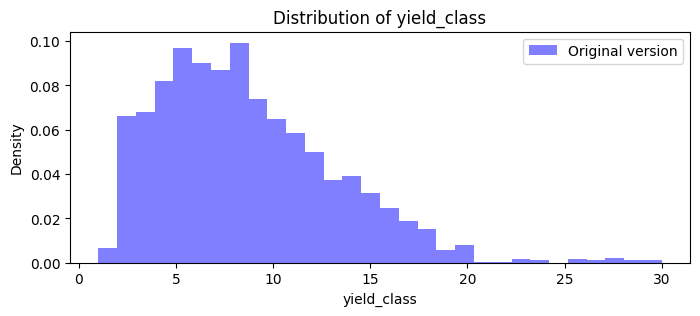

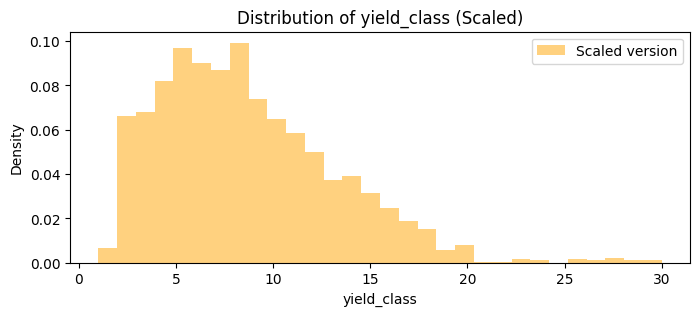

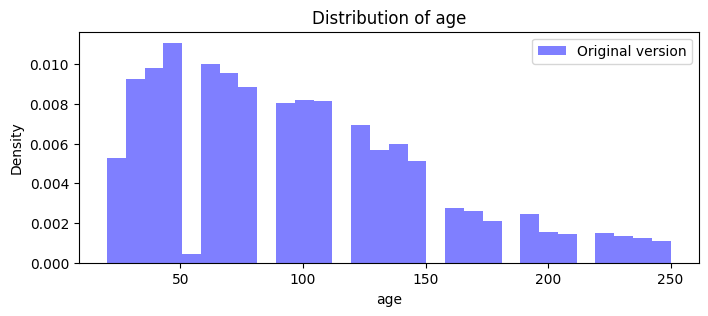

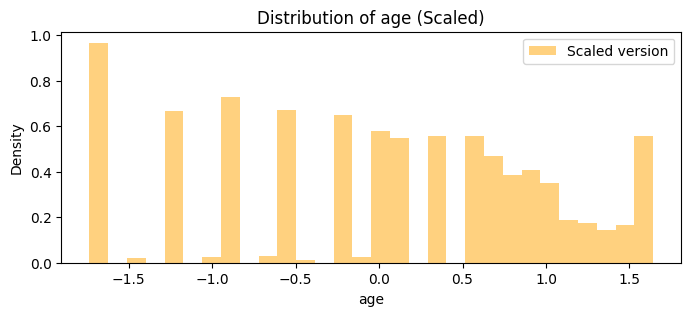

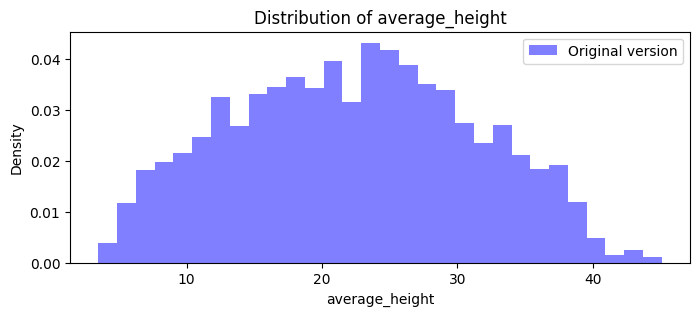

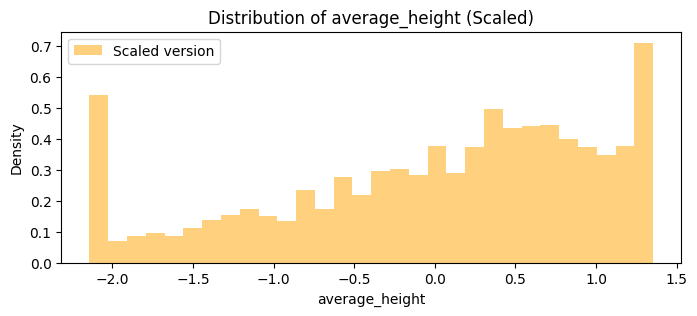

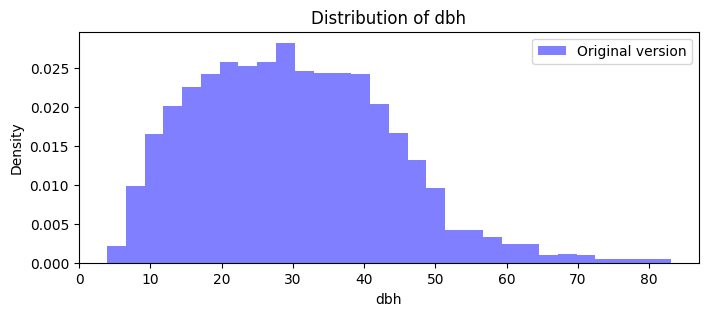

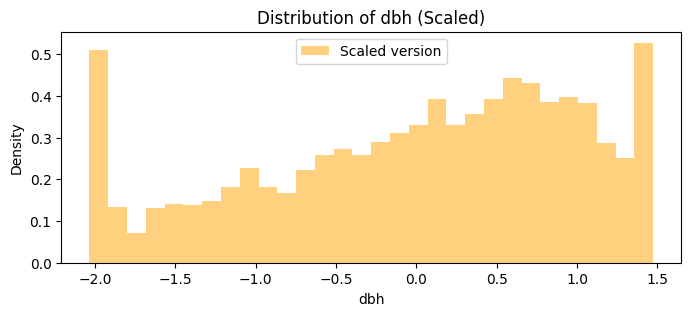

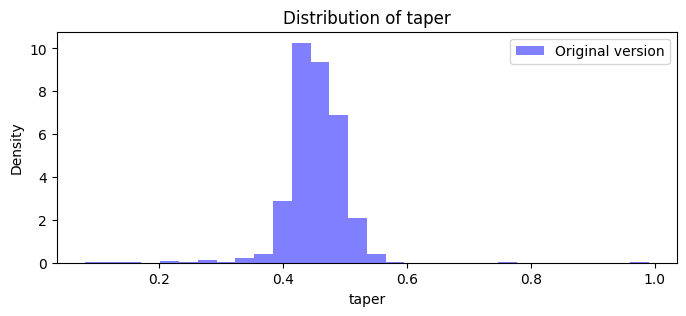

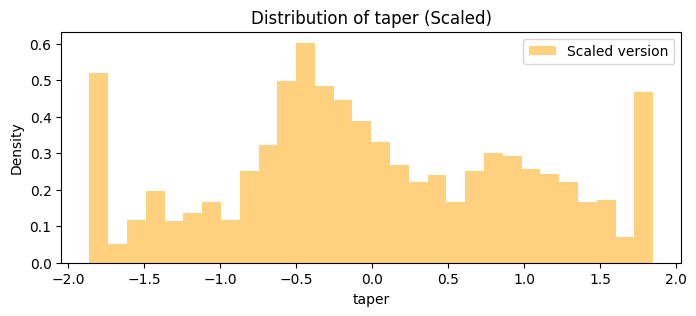

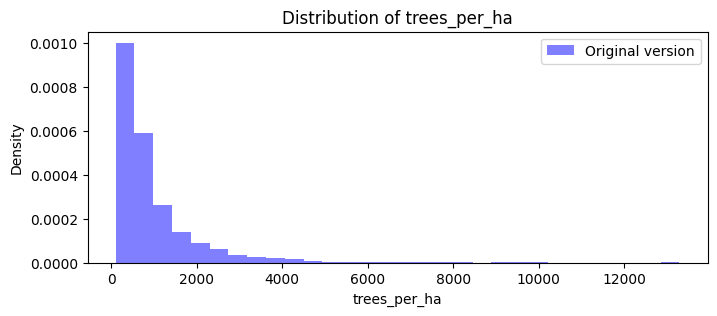

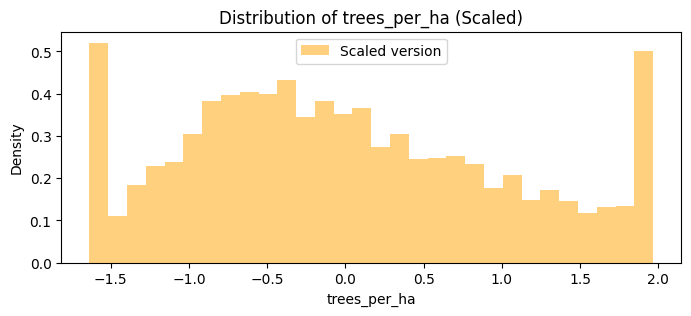

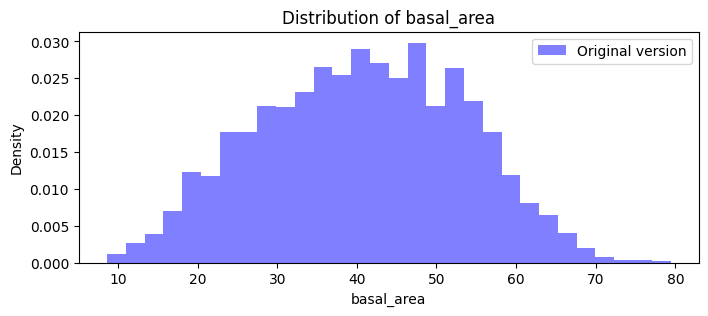

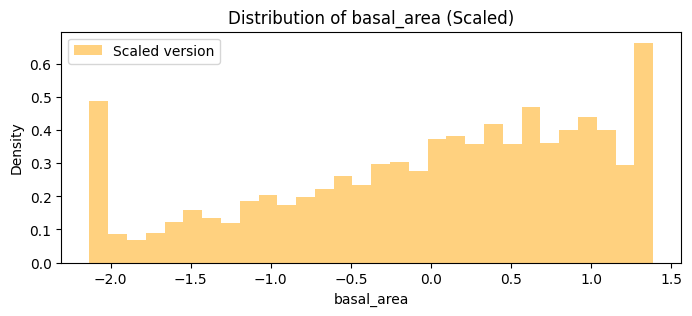

In [95]:
for feature in X_train.columns:
    plt.figure(figsize=(8, 3))
    plt.hist(
        X_train[feature],
        bins=30,
        alpha=0.5,
        label="Original version",
        color="blue",
        density=True,
    )
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 3))
    plt.hist(
        X_train_scaled[feature],
        bins=30,
        alpha=0.5,
        label="Scaled version",
        color="orange",
        density=True,
    )
    plt.title(f"Distribution of {feature} (Scaled)")
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.legend()
    plt.show()

In [96]:
# Save the data
X_train_scaled.to_csv("../data/processed/X_train.csv", index=False)
X_val_scaled.to_csv("../data/processed/X_val.csv", index=False)
X_test_scaled.to_csv("../data/processed/X_test.csv", index=False)
y_train.to_csv("../data/processed/y_train.csv", index=False)
y_val.to_csv("../data/processed/y_val.csv", index=False)
y_test.to_csv("../data/processed/y_test.csv", index=False)